In [8]:
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [17]:
# Plotting Functions

def plot_before_after(original_image, reconstructed_image, color: bool = True):
    image1 = cv2.cvtColor(cv2.normalize(original_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(cv2.normalize(reconstructed_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    if color:
        ax[0].imshow(image1)
        ax[1].imshow(image2)
    else:
        ax[0].imshow(image1, cmap="gray")
        ax[1].imshow(image2, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].set_title("Deconvolved Image")
    ax[1].axis("off")
    plt.show()

def plot_wavelet_planes(wavelet_planes, color: bool = True):
    num_levels = len(wavelet_planes[0])
    if color:
        channel_names = ["Red", "Green", "Blue"]
        for idx, planes in enumerate(wavelet_planes):
            fig, axes = plt.subplots(1, num_levels, figsize=(12, 5))
            for level, plane in enumerate(planes):
                axes[level].imshow(plane, cmap="gray")
                axes[level].set_title(f"{channel_names[idx]} - Level {level+1}")
                axes[level].axis("off")
            plt.suptitle(f"Wavelet Planes for {channel_names[idx]} Channel")
            plt.show()
    else:
        fig, axes = plt.subplots(1, num_levels, figsize=(12, 5))
        for level, plane in enumerate(wavelet_planes[0]):
            axes[level].imshow(plane, cmap="gray")
            axes[level].set_title(f"Level {level+1}")
            axes[level].axis("off")
        plt.suptitle("Wavelet Planes")
        plt.show()


uint16


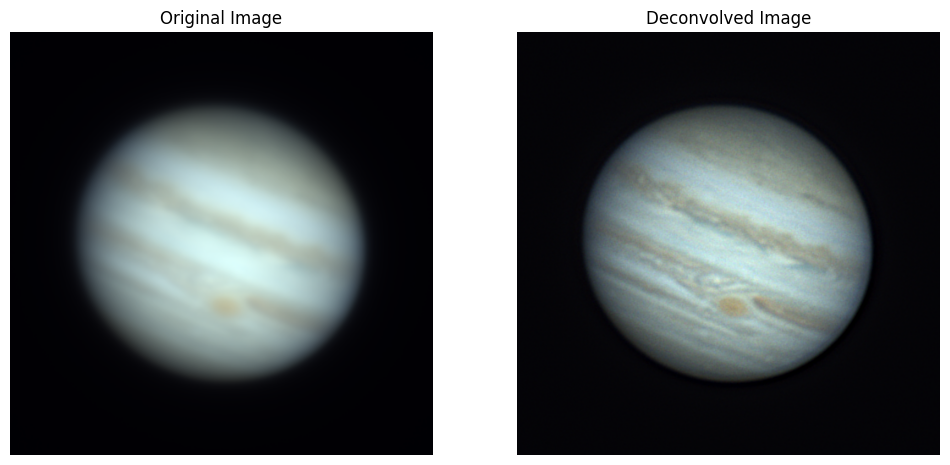

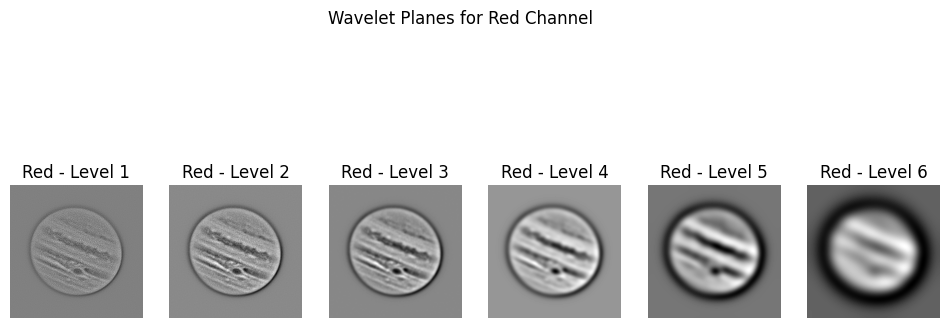

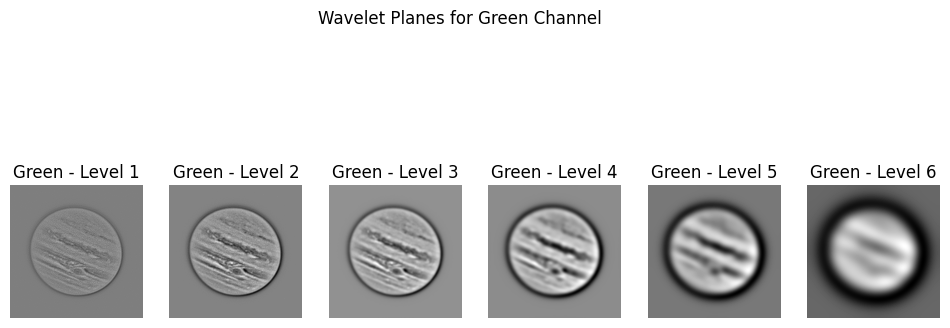

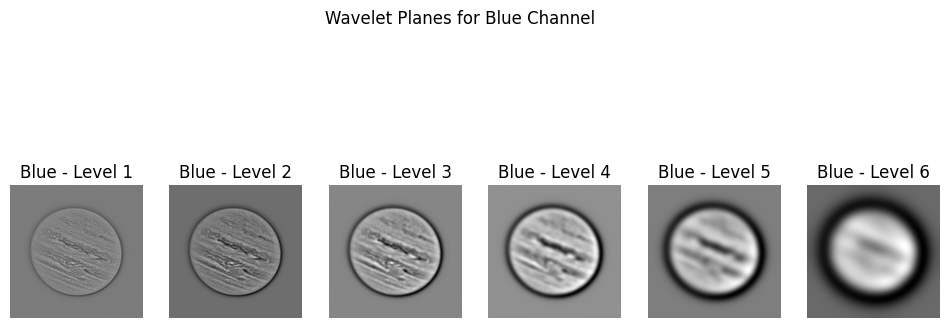

True

In [22]:
def process_channel(channel_data, levels, gain_factors):
    coeffs = []
    residual = channel_data.copy()
    wavelet_planes = []
    for level in range(levels):
        sigma = 2 ** level
        smoothed = gaussian_filter(residual, sigma=sigma)
        wavelet_plane = residual - smoothed
        # store wavelet plane before applying gain
        wavelet_planes.append(wavelet_plane.copy())
        gain = gain_factors[level]
        wavelet_plane *= gain
        coeffs.append(wavelet_plane)
        # update
        residual = smoothed

    reconstructed_channel = residual + sum(coeffs)
    return reconstructed_channel, wavelet_planes


def atrous_wavelet_deconvolution(image, levels, gain_factors, color=True):

    data = image.astype(np.float32) / 65536.0
    
    if color:
        # data = image.astype(np.float32) / 65536.0
        channels = []
        all_wavelet_planes = []
        for i in range(3): 
            channel = data[:, :, i]
            reconstructed_channel, wavelet_planes = process_channel(channel, levels, gain_factors)
            channels.append(reconstructed_channel)
            all_wavelet_planes.append(wavelet_planes)
        reconstructed_data = np.stack(channels, axis=2)
    else:
        reconstructed_data, wavelet_planes = process_channel(data, levels, gain_factors)
        all_wavelet_planes = [wavelet_planes] 

    reconstructed_data = np.clip(reconstructed_data, 0, 1)
    
    if color:
        reconstructed_image = (reconstructed_data * 65536).astype(np.uint16)
    else:
        reconstructed_image = (reconstructed_data * 65536).astype(np.uint16)
    

    if color:
        plot_before_after(image, reconstructed_image, color=True)
        plot_wavelet_planes(all_wavelet_planes, color=True)
    else:
        plot_before_after(image, reconstructed_image, color=False)
        plot_wavelet_planes(all_wavelet_planes, color=False)
    
    return reconstructed_image

# Example usage:
image_path = "../src/images/stacked_jupiter.tiff"   # Replace with your image path
# image = Image.open(image_path)
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
print(image.dtype)


levels = 6  # Number of decomposition levels
gain_factors = [20.0, 20.0, 1.0, 1.0, 1.0, 1.0]  # Gain factors for each level

# For grayscale processing:
# reconstructed_image = atrous_wavelet_deconvolution(image, levels, gain_factors, color=False)

# For color processing:
reconstructed_image = atrous_wavelet_deconvolution(image, levels, gain_factors, color=True)

# Save the reconstructed image
# reconstructed_image.save("./reconstructed_image.tiff")
cv2.imwrite("./reconstructed_image.tiff", reconstructed_image)